In [10]:
# IMPORT DEPENDANCIES

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import integrate
from IPython.display import HTML, display
from scipy.stats import norm
from scipy.stats import t as the

%matplotlib inline
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

In [11]:
from notebook.services.config import ConfigManager
ConfigManager().update('notebook', {'ExecuteTime': {
    'display_absolute_timestamps': True,
    'relative_timing_update_period': 5,
    'template': {
        'executed': 'started ${start_time}, finished in ${duration}',
    }
}})



{'Notebook': {'Header': True},
 'ExecuteTime': {'display_absolute_timestamps': True,
  'relative_timing_update_period': 5,
  'template': {'executed': 'started ${start_time}, finished in ${duration}'}}}

In [12]:
# DEFINE ACTIVITIES

activity_id = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

#Protocol Activities: lie, sit, stand, walk, run, cycle, Nordic walk, iron, vacuum cleaning, 
#rope jump, ascend and descend stairs
protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]

#Optional Activities: watch TV, computer work, drive car, fold laundry, house cleaning, play soccer
optional_acts = [9,10,11,18,19,20]

#Soldier Activities: transient, lying, sitting, standing, walking, running, hiking, operating C2, operating vehicle,
#ascending stairs, descending stairs, jumping (rope), and house cleaning (misc tasks)
soldier_acts = [1,2,3,4,5,7,10,11,12,13,24,19]

#MET Classification of activities as low, medium, or high

#lying, sitting, and standing
low_activity = [1,2,3,17]
#descending stairs, walking, Nordic walking (hiking), and house cleaning (misc tasks)
medium_activity = [4,6,7,13,16, 19]
#ascending stairs, running, and jumping (rope)
high_activity = [5,12,24]


def map_met(act_id):
    if act_id in low_activity:
        return 'low'
    if act_id in medium_activity:
        return 'medium'
    if act_id in high_activity:
        return 'high'
    
col_names=['timestamp', 'activity_id', 'heart_rate']

IMU_locations = ['hand', 'chest', 'ankle']
IMU_data = ['tmp', 'acc_16_01', 'acc_16_02', 'acc_16_03',
            'acc_06_01', 'acc_06_02', 'acc_06_03',
            'gyr_01', 'gyr_02', 'gyr_03',
            'mag_01', 'mag_02', 'mag_03',
            'ori_01', 'ori_02', 'ori_03', 'ori_04']

col_names = col_names + [item for sublist in [[dat+'_'+loc for dat in IMU_data] for loc in IMU_locations] for item in sublist]

In [13]:
# LOAD DATA

files = [
    'PAMAP2_Dataset/Protocol/subject101.dat',
    'PAMAP2_Dataset/Protocol/subject102.dat',
    'PAMAP2_Dataset/Protocol/subject103.dat',
    'PAMAP2_Dataset/Protocol/subject104.dat',
    'PAMAP2_Dataset/Protocol/subject105.dat',
    'PAMAP2_Dataset/Protocol/subject106.dat',
    'PAMAP2_Dataset/Protocol/subject107.dat',
    'PAMAP2_Dataset/Protocol/subject108.dat',
    'PAMAP2_Dataset/Protocol/subject109.dat'
]

pamap2 = pd.DataFrame()

for file in files:
    sub_data = pd.read_table(file, header=None, sep='\s+')
    sub_data.columns = col_names
    sub_data['sub_id'] = int(file[-5])
    sub_data['act_level'] = sub_data['activity_id'].apply(map_met)
    pamap2 = pamap2.append(sub_data, ignore_index=True)
    

In [14]:
# THIN OUT DATA

drop_index = []

#Getting indexes of activity 0
drop_index += list(pamap2.index[pamap2['activity_id']==0])

#Keep only activities as documented on file "PerformedActivitiesSummary.pdf"
drop_index += list(pamap2.index[(pamap2['sub_id']==1) & (pamap2['activity_id'].isin([10,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==2) & (pamap2['activity_id'].isin([9,10,11,18,19,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==3) & (pamap2['activity_id'].isin([5,6,7,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==4) & (pamap2['activity_id'].isin([5,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==5) & (pamap2['activity_id'].isin([9,11,18,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==6) & (pamap2['activity_id'].isin([9,11,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==7) & (pamap2['activity_id'].isin([9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==8) & (pamap2['activity_id'].isin([9,11]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==9) & (pamap2['activity_id'].isin([1,2,3,4,5,6,7,9,11,12,13,16,17]))])

pamap2 = pamap2.drop(drop_index)
    
#Interpolate data
pamap2 = pamap2.interpolate()


In [15]:
# CLEAN DATA

freq = 100
pamap2['act_block'] = ((pamap2['activity_id'].shift(1) != pamap2['activity_id']) | (pamap2['sub_id'].shift(1) != pamap2['sub_id'])).astype(int).cumsum()
drop_index = []
numblocks = pamap2['act_block'].max()
for block in range(1, numblocks+1):
    drop_index += list(pamap2[pamap2['act_block']==block].head(10 * freq).index)
    drop_index += list(pamap2[pamap2['act_block']==block].tail(10 * freq).index)
    
pamap2 = pamap2.drop(drop_index)


In [7]:
pamap2.head(100)


,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_level,act_block
3928,47.66,1,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.428290,4.59099,-9.911060,-1.667120,4.60909,-9.668380,-1.696650,0.073002,0.284169,44.5122,-11.2486,51.24430,1.0,0.0,0.0,0.0,30.875,9.356030,1.448820,-3.44087,9.482080,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,low,1
3929,47.67,1,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.302410,4.63088,-9.521700,-1.621060,4.68434,-9.592870,-1.778710,0.069577,0.317669,44.0021,-12.7925,50.86680,1.0,0.0,0.0,0.0,30.875,9.457720,1.108960,-3.74644,9.407290,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,low,1
3930,47.68,1,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.109250,4.74376,-9.441130,-1.484310,4.77441,-9.457420,-1.757580,0.041567,0.325210,44.5969,-13.3610,49.77180,1.0,0.0,0.0,0.0,30.875,8.735770,0.508215,-4.02024,9.136370,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,low,1
3931,47.69,1,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.178960,5.04652,-9.249770,-1.437260,4.86454,-9.230760,-1.841740,-0.005494,0.366242,44.5062,-13.9122,49.27940,1.0,0.0,0.0,0.0,30.875,9.520780,0.959822,-4.13076,8.820060,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,low,1
3932,47.70,1,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.287090,5.23644,-9.058740,-1.480140,5.07573,-9.078760,-1.853510,-0.055315,0.391737,44.3054,-14.8072,50.13320,1.0,0.0,0.0,0.0,30.875,9.255100,0.886508,-4.24880,9.344720,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,low,1
3933,47.71,1,103.0,30.5,-7.34474,-7.02544,-0.084712,-7.21878,-7.19540,-0.088787,0.756132,-0.291966,0.195382,9.54110,51.5274,-20.8937,1.0,0.0,0.0,0.0,32.3125,-1.099990,5.64900,-9.211580,-1.447590,5.37739,-8.987400,-1.869250,-0.077624,0.466869,45.1543,-16.0502,48.55090,1.0,0.0,0.0,0.0,30.875,9.036870,0.619902,-3.97926,8.983960,0.949629,-3.94713,0.009023,-0.256057,0.232798,-76.3084,-45.7171,-40.6394,1.0,0.0,0.0,0.0,1,low,1
3934,47.72,1,103.0,30.5,-7.67549,-6.83110,0.140603,-7.47258,-7.11786,0.122713,0.845222,-0.310498,0.164195,9.64515,52.3992,-21.4642,1.0,0.0,0.0,0.0,32.3125,-1.163040,5.87801,-8.787530,-1.354790,5.70913,-8.911440,-1.934730,-0.075978,0.495424,44.9454,-16.6042,48.79210,1.0,0.0,0.0,0.0,30.875,9.521000,0.579494,-4.05122,9.059700,0.738100,-3.78037,-0.018201,-0.281838,0.237998,-76.0727,-45.6361,-39.0313,1.0,0.0,0.0,0.0,1,low,1
3935,47.73,1,103.0,30.5,-7.79208,-6.52806,-0.016116,-7.59137,-6.87540,0.092102,0.985834,-0.254816,0.122707,10.18830,51.1769,-21.9465,1.0,0.0,0.0,0.0,32.3125,-1.088800,5.99021,-8.864000,-1.292540,5.96546,-8.835510,-1.972350,-0.149502,0.515534,43.5176,-17.7776,47.91080,1.0,0.0,0.0,0.0,3

In [16]:
# DEFINE WINDOWS AND FEATURES

freq = 100
windowsize = int(5.12 * freq)
displacement = 1*freq

#columns used for analysis
columns_used = ['sub_id', 'activity_id', 'act_level', 'heart_rate',
                'tmp_hand','acc_16_01_hand','acc_16_02_hand','acc_16_03_hand',
                'gyr_01_hand','gyr_02_hand','gyr_03_hand',
                'tmp_chest','acc_16_01_chest','acc_16_02_chest','acc_16_03_chest',
                'gyr_01_chest','gyr_02_chest','gyr_03_chest',
                'tmp_ankle','acc_16_01_ankle','acc_16_02_ankle','acc_16_03_ankle',
                'gyr_01_ankle','gyr_02_ankle','gyr_03_ankle']

#resting HR for participating subjects, used for normalisation
sub_rest_hr = {1:75, 2:74, 3:68, 4:58, 5:70, 6:60, 7:60, 8:66, 9:54}

windows = []

#Sliding window of 5.12 seconds, equaling 512 instances of data, with 1 second of overlap
for block in range(1, numblocks+1):
    ar = np.array(pamap2[pamap2['act_block']==block][columns_used])
    start_index = 0
    while True:
        if len(ar[start_index:start_index+windowsize,:])<512:
            break
        windows.append(ar[start_index:start_index+windowsize,:])
        start_index += displacement

#Next the features for each window are calculated
window_features = []
for window in windows:
    features = []
    #Adding Subject ID, Activity ID and Activity Level for ground truth
    features.append(window[0][0])
    features.append(window[0][1])
    features.append(window[0][2])
    #Computing mean, normalised mean and std for HR data
    features.append(np.mean(window[:,3]))
    features.append(np.mean(window[:,3]/sub_rest_hr[window[0][0]]))
    features.append(np.std(window[:,3]))
    features.append(np.std(window[:,3]/sub_rest_hr[window[0][0]]))
    #Computing mean and std for the rest of the columns
    for col in range(4,25):
        features.append(np.mean(window[:,col]))
        features.append(np.std(window[:,col]))
    #Computing correlation between axes for hand Accelerometer    
    features.append(stats.spearmanr(window[:,5],window[:,6])[0])
    features.append(stats.spearmanr(window[:,6],window[:,7])[0])
    features.append(stats.spearmanr(window[:,5],window[:,7])[0])
    #Computing correlation between axes for chest Accelerometer  
    features.append(stats.spearmanr(window[:,12],window[:,13])[0])
    features.append(stats.spearmanr(window[:,13],window[:,14])[0])
    features.append(stats.spearmanr(window[:,12],window[:,14])[0])
    #Computing correlation between axes for ankle Accelerometer
    features.append(stats.spearmanr(window[:,19],window[:,20])[0])
    features.append(stats.spearmanr(window[:,20],window[:,21])[0])
    features.append(stats.spearmanr(window[:,19],window[:,21])[0])
    #Computing correlation between axes for hand Gyroscope    
    features.append(stats.spearmanr(window[:,8],window[:,9])[0])
    features.append(stats.spearmanr(window[:,9],window[:,10])[0])
    features.append(stats.spearmanr(window[:,8],window[:,10])[0])
    #Computing correlation between axes for chest Gyroscope  
    features.append(stats.spearmanr(window[:,15],window[:,16])[0])
    features.append(stats.spearmanr(window[:,16],window[:,17])[0])
    features.append(stats.spearmanr(window[:,15],window[:,17])[0])
    #Computing correlation between axes for ankle Gyroscope
    features.append(stats.spearmanr(window[:,22],window[:,23])[0])
    features.append(stats.spearmanr(window[:,23],window[:,24])[0])
    features.append(stats.spearmanr(window[:,22],window[:,24])[0])
    window_features.append(features)

#new dataframe with features for each window
features = pd.DataFrame(window_features)


In [68]:

features.head()


,sub_id,activity_id,act_level,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
0,1,1,low,103.951172,1.386016,0.805429,0.010739,30.523682,0.030320,-1.879247,3.534154,4.788385,2.567330,6.990495,1.965119,0.107901,0.466133,-0.251155,0.366370,0.211265,0.456911,32.323120,0.023473,1.521597,1.132801,5.122803,3.014503,5.573594,5.041338,-0.487434,0.561027,-0.086311,0.294916,0.101015,0.336984,30.900513,0.030719,2.413188,3.686631,-7.901836,3.011201,-4.319748,1.431167,-0.027212,0.486969,0.053937,0.474670,0.407518,0.913272,0.464139,0.055267,0.510214,0.511312,-0.799051,-0.302004,0.264226,-0.113223,0.314868,-0.531362,-0.581758,0.530794,0.230082,-0.481656,-0.604763,0.325803,-0.294619,-0.170427
1,1,1,low,104.509766,1.393464,0.952667,0.012702,30.535889,0.030904,-0.185149,1.377860,5.695728,0.972648,7.785865,0.751240,-0.009273,0.381659,-0.113646,0.258900,0.043581,0.215902,32.335327,0.030093,1.475562,1.023636,3.805870,2.555193,8.036729,2.391985,-0.255809,0.411611,0.009638,0.174810,-0.005376,0.236450,30.912720,0.030573,0.609043,1.205205,-8.821382,1.874376,-4.609152,1.303216,-0.045085,0.330023,0.014152,0.202536,0.046104,0.258117,0.028908,-0.684904,0.096735,0.619179,-0.638843,-0.491480,-0.427727,-0.389651,0.486994,-0.282832,-0.248817,0.230088,-0.118856,-0.139842,-0.481102,0.194234,-0.368513,-0.292237
2,1,1,low,105.253906,1.403385,1.094676,0.014596,30.548096,0.026321,0.319354,0.447698,5.626324,0.819042,7.950312,0.582057,-0.037028,0.274945,-0.016048,0.083449,-0.029576,0.083680,32.347534,0.031020,1.085746,0.737306,2.650548,1.082055,9.169791,0.582381,-0.111460,0.330841,0.024648,0.143875,-0.048026,0.205479,30.924927,0.025055,0.226354,1.141336,-8.691025,1.764263,-4.796809,1.227335,-0.031455,0.262951,-0.013533,0.102034,0.037852,0.237697,0.129201,-0.685796,-0.184500,0.190822,-0.328401,-0.034166,-0.562640,-0.522007,0.588619,-0.162304,0.219523,0.154424,-0.130829,-0.111774,-0.385171,0.214233,-0.311803,-0.179082
3,1,1,low,105.839844,1.411198,1.069291,0.014257,30.555542,0.019659,0.322273,0.326337,5.483047,0.568834,8.098098,0.372352,0.029006,0.152585,0.000316,0.055307,-0.006781,0.042133,32.359741,0.026849,0.875531,0.400173,2.274730,0.498286,9.317323,0.253320,-0.035471,0.129909,-0.000624,0.093716,0.017624,0.097199,30.937134,0.004770,-0.141292,0.981405,-8.506603,1.748027,-5.133278,1.202987,-0.051114,0.199645,-0.012446,0.088246,0.053858,0.207330,0.134870,-0.670430,-0.109069,-0.280928,-0.168570,0.215786,-0.328764,-0.544402,0.499454,-0.300674,0.085189,-0.138638,0.257661,-0.379470,-0.646042,0.187620,-0.438468,-0.192798
4,1,1,low,106.339844,1.417865,0.853795,0.011384,30.558350,0.015562,0.316246,0.102791,5.702229,0.209482,7.966321,0.143267,0.009624,0.092451,0.001428,0.025731,-0.010280,0.025021,32.371948,0.013469,0.958177,0.216285,2.088273,0.369734,9.364349,0.213946,-0.006847,0.072573,-0.006268,0.058533,-0.006317,0.067592,30.937500,0.000000,-0.584390,0.345254,-8.254930,1.697411,-5.647530,0.819204,-0.053999,0.155904,-0.009388,0.079133,0.039167,0.198324,-0.089136,-0.450723,0.222441,-0.109808,-0.121974,0.081106,0.164706,-0.425811,0.1

In [36]:
# CREATE TRAIN AND TEST DATAFRAMES

feature_names = ['sub_id','activity_id','act_level','hr_mean','hr_mean_normal','hr_std', 'hr_std_normal']
locs = ['hand','chest','ankle']
cols = ['tmp','acc_x','acc_y','acc_z', 'gyr_x','gyr_y','gyr_z']
feats = ['mean','std']

for loc in locs:
    for col in cols:
        for feat in feats:
            feature_names.append(loc + '_' + col + '_' + feat)
for loc in locs:
    feature_names += [loc + '_acc_xy_cor', loc + '_acc_yz_cor', loc + '_acc_xz_cor']

for loc in locs:
    feature_names += [loc + '_gyr_xy_cor', loc + '_gyr_yz_cor', loc + '_gyr_xz_cor']

features.columns = feature_names

#Using a seed to facilitate replication of results
train_data_df = features.sample(frac=0.7, random_state=1)
test_data_df = features.drop(train_data_df.index)


In [37]:
train_data_df.head()


,sub_id,activity_id,act_level,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
3006,2,17,low,87.000000,1.175676,0.000000,7.105427e-15,34.3750,0.0,-1.165524,2.383779,3.381285,2.582771,8.492507,1.224852,0.093030,0.719383,-0.080050,0.494687,-0.170838,0.980066,37.750000,0.000000,-0.574081,0.956643,8.924554,0.575753,-4.355411,0.852119,0.052130,0.172671,-0.127863,0.550284,0.069405,0.261474,35.1250,0.0,9.613680,0.141006,-2.034883,0.449276,-0.675058,0.722426,0.003878,0.260395,-0.039163,0.099164,0.003677,0.141914,0.614900,-0.749890,-0.252158,-0.096426,0.451917,-0.137126,0.291370,-0.242012,0.233251,-0.472662,0.335516,-0.377507,-0.290138,-0.779952,0.071855,-0.305959,-0.003001,-0.638866
3497,2,4,medium,124.605469,1.683858,0.927920,1.253946e-02,31.8750,0.0,-12.040995,3.734766,3.069947,2.591651,1.161251,1.837110,0.055998,2.159256,-0.031960,0.962742,0.089741,3.720493,36.500000,0.000000,0.526051,2.046854,8.318571,2.496176,-5.332919,2.201650,0.022321,0.314681,-0.036313,0.806525,-0.011805,0.666682,34.5625,0.0,11.712190,5.814112,0.068395,7.408032,-1.578947,3.224426,-0.089607,1.419706,-0.109581,0.823423,-0.033989,3.099118,-0.238044,-0.186898,0.162161,-0.007312,-0.513200,0.059846,0.128946,-0.270560,-0.119772,-0.287380,-0.230390,-0.491314,0.011124,-0.799319,-0.135736,-0.653133,-0.654575,0.391363
14495,7,5,high,113.493430,1.891557,2.315888,3.859813e-02,32.5000,0.0,-3.723040,10.188184,11.705779,17.220389,-1.367870,4.527840,0.186308,2.657634,0.321703,2.115963,-0.036559,2.807273,36.756836,0.019507,0.740500,3.648823,9.913660,11.646691,-0.689218,3.454264,0.064076,0.904309,0.242770,1.406050,-0.009270,0.686093,32.0000,0.0,14.272593,19.002270,4.774907,16.373748,-4.488213,13.319767,0.268098,2.850637,-0.214467,1.461636,0.173994,4.399006,-0.226895,-0.685601,0.441670,-0.033515,0.167499,-0.246121,-0.083889,0.418781,0.025673,-0.265566,0.824691,-0.121345,-0.004923,-0.317761,-0.202148,-0.660278,-0.528138,0.402147
13278,7,17,low,82.513672,1.375228,0.492657,8.210948e-03,33.8125,0.0,-3.618932,1.935690,0.542981,2.907890,8.430229,0.975924,-0.163251,0.502349,0.209826,0.456587,0.271169,0.886100,36.750000,0.000000,0.185189,1.393045,9.358609,0.220221,-3.092576,0.264225,0.003291,0.064052,0.034760,0.096851,-0.095510,0.132262,32.8125,0.0,9.280206,0.111226,-0.821241,0.193480,-3.597638,0.332495,0.007408,0.061254,0.007822,0.044353,0.009165,0.047432,0.435401,0.031484,0.092153,-0.458219,0.108914,-0.342861,-0.274557,-0.555554,0.724061,-0.196728,0.315984,-0.380337,0.284190,-0.109078,-0.071734,-0.177813,0.237828,-0.729771
14969,8,3,low,73.000000,1.106061,0.000000,7.327472e-15,34.4375,0.0,-9.275877,0.082824,1.006239,0.153816,2.709588,0.155286,-0.008753,0.049173,0.002632,0.025952,-0.001796,0.027531,37.562500,0.000000,-1.116647,0.108927,9.665873,0.098028,0.706836,0.171972,0.010735,0.044164,0.004822,0.046422,-0.016413,0.019973,34.1250,0.0,6.686333,0.077043,-7.266617,0.080816,-1.471347,0.167118,-0.000961,0.039025,0.000421,0.028817,0.005620,0.017938,0.221818,-0.077456,0.344009,0.069912,0.031856,0.127825,0.468236,-0.292715,-0.001651,-0.060776,0.165

In [31]:
train_data_df.describe()

,sub_id,activity_id,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
count,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000
mean,4.566551,7.851270,106.417933,1.608084,0.614128,0.009396,32.747195,0.011363,-4.882529,2.960515,3.579399,3.369920,3.728024,1.985928,0.003584,1.009802,0.038053,0.674177,-0.005636,1.167451,36.172138,0.011275,0.320277,1.141133,8.001675,2.403729,-1.459401,1.412660,0.005283,0.311351,0.011220,0.378151,-0.022430,0.243291,33.715775,0.010482,9.352390,3.660324,-0.209262,4.784479,-2.617242,2.447640,0.008281,0.815022,-0.038511,0.452300,0.006574,1.417495,0.012056,0.031707,-0.022429,0.083605,0.016514,0.058841,0.092657,-0.090294,0.056462,-0.161015,0.004575,-0.163462,-0.048024,-0.187658,-0.162419,-0.100640,-0.044313,0.029267
std,2.333171,6.144114,26.600993,0.410028,0.599574,0.009564,1.795994,0.012879,4.681096,3.035948,4.348022,4.416380,3.028981,1.642579,0.253117,0.821678,0.176810,0.667937,0.154522,1.135898,1.488611,0.012875,1.010742,0.898048,2.944727,3.244810,4.560487,1.276754,0.042905,0.321744,0.185436,0.366177,0.074117,0.194694,1.082887,0.012711,3.620480,4.210675,3.488218,5.222210,1.664856,2.595367,0.187024,0.746131,0.123149,0.436108,0.092571,1.494692,0.337413,0.393818,0.326127,0.234081,0.378425,0.269028,0.233055,0.313239,0.319038,0.330463,0.464010,0.308965,0.214986,0.331273,0.225753,0.333526,0.492940,0.310010
min,1.000000,1.000000,57.004972,0.982844,0.000000,0.000000,24.995972,0.000000,-21.143877,0.055469,-14.507034,0.053657,-8.447890,0.084457,-1.556403,0.019851,-0.767221,0.018237,-0.990106,0.014115,32.000000,0.000000,-5.093732,0.054961,-3.865283,0.054137,-10.137696,0.087936,-0.334105,0.020047,-1.207619,0.018889,-0.494949,0.014941,30.092163,0.000000,-1.454787,0.047345,-9.862678,0.047702,-10.106230,0.080023,-1.132280,0.021322,-0.672501,0.020376,-0.405945,0.014242,-0.904784,-0.963125,-0.940799,-0.878690,-0.956835,-0.879922,-0.901223,-0.912199,-0.866485,-0.923141,-0.977078,-0.922794,-0.868709,-0.958057,-0.922082,-0.886736,-0.941531,-0.947281
25%,2.000000,3.000000,85.299805,1.258937,0.334099,0.004890,31.625000,0.000000,-8.673713,0.552259,2.064050,0.802393,1.709905,0.721232,-0.060746,0.340597,-0.013645,0.177101,-0.053695,0.180450,35.187500,0.000000,-0.012093,0.301780,8.043105,0.19903

In [32]:
test_data_df.describe()

,sub_id,activity_id,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
count,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000
mean,4.567182,7.919937,106.927438,1.618433,0.620876,0.009508,32.761520,0.010951,-4.942754,2.985041,3.507952,3.355167,3.732188,2.011457,-0.003304,1.036098,0.044660,0.676066,-0.003084,1.174837,36.166267,0.011127,0.334922,1.154836,8.028685,2.456031,-1.382337,1.437885,0.005509,0.312422,0.015390,0.384944,-0.024270,0.244465,33.697955,0.010463,9.355941,3.748412,-0.240438,4.904131,-2.652089,2.504154,0.014454,0.835191,-0.036513,0.462427,0.008466,1.443081,0.013410,0.030261,-0.025881,0.082818,0.013177,0.055833,0.085247,-0.102950,0.052538,-0.155315,-0.001384,-0.164079,-0.047534,-0.186203,-0.161452,-0.094245,-0.028988,0.034080
std,2.317115,6.164955,26.555741,0.411472,0.539332,0.008433,1.765130,0.012797,4.702730,3.059917,4.359122,4.330293,2.973435,1.667935,0.272537,0.838656,0.184571,0.669453,0.156301,1.142859,1.486808,0.012768,0.941868,0.897250,2.924349,3.291919,4.561132,1.293619,0.043442,0.324793,0.196982,0.360444,0.070640,0.189850,1.092988,0.012635,3.630677,4.255220,3.499420,5.261461,1.664088,2.627831,0.195305,0.750248,0.126648,0.442179,0.091893,1.497854,0.340843,0.389045,0.326677,0.232468,0.376792,0.263223,0.232428,0.307137,0.314199,0.329397,0.457812,0.305523,0.217986,0.331269,0.228761,0.328728,0.496906,0.308750
min,1.000000,1.000000,57.000000,0.982759,0.000000,0.000000,24.983765,0.000000,-24.123314,0.056700,-14.605581,0.055163,-8.236639,0.087788,-1.765292,0.019015,-0.722071,0.018673,-0.903257,0.014420,31.993774,0.000000,-4.070448,0.056605,-2.248834,0.054905,-10.149587,0.088039,-0.487434,0.019635,-1.204935,0.019365,-0.420700,0.015291,30.125000,0.000000,-1.262755,0.046824,-9.840345,0.048067,-10.069933,0.083147,-1.047834,0.021591,-0.627596,0.020247,-0.407946,0.014115,-0.879615,-0.919723,-0.894994,-0.874955,-0.961742,-0.907171,-0.825808,-0.930825,-0.853671,-0.924937,-0.973199,-0.873602,-0.806866,-0.942768,-0.937755,-0.857645,-0.937148,-0.947303
25%,2.000000,3.000000,85.866211,1.270832,0.342872,0.005104,31.632996,0.000000,-8.756180,0.616022,1.955498,0.871882,1.722565,0.765610,-0.066241,0.353756,-0.010908,0.175466,-0.052700,0.188778,35.169891,0.000000,0.006494,0.295313,8.089212,0.199617,-4.288626,0.333006,-0.004820,0.086607,-0.014357,0.098570,-0.032

In [ ]:
# CREATE CSV FILES


In [87]:
#Save the features dataframes to local files
train_data_df.to_csv("train_data.csv", index=False)
test_data_df.to_csv("test_data.csv", index=False)

In [88]:
#Read features from csv files
#train_data_df = pd.read_csv("train_data.csv", header=0)
#test_data_df = pd.read_csv("test_data.csv", header=0)

In [89]:
# ACTIVITY CALSSIFICATION

Train Dataset by Activity


rope jumping         1539
walking              1525
standing             1220
lying                1203
computer work        1196
sitting              1162
descending stairs    1099
Nordic walking       1035
running               593
car driving           522
ascending stairs      428
house cleaning        251
Name: Activity Counts, dtype: int64

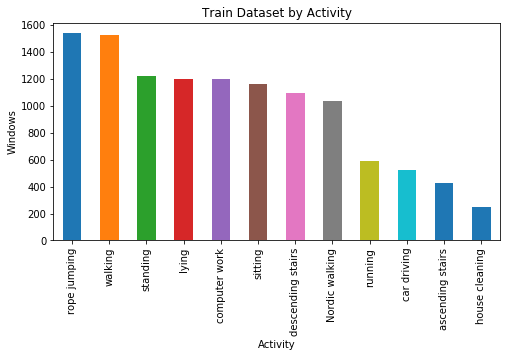

In [18]:
s = train_data_df.groupby('activity_id').count()['act_level']
s = s.rename("Activity Counts")
s.index = [activity_id[x] for x in soldier_acts]
print(('Train Dataset by Activity'))
display(s.sort_values(ascending =False))
ax = s.sort_values(ascending =False).plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('Windows')
_ = ax.set_xlabel('Activity')
_ = ax.set_title('Train Dataset by Activity')


Train Dataset by Activity Intensity Level


act_level
high      1366
low       5124
medium    5283
Name: Activity Level Counts, dtype: int64

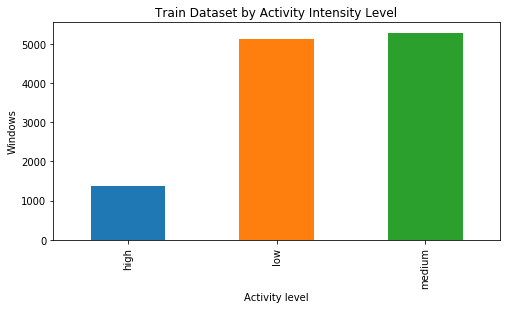

In [19]:
s = train_data_df.groupby('act_level').count()['activity_id']
s = s.rename("Activity Level Counts")
print(('Train Dataset by Activity Intensity Level'))
display(s)
ax = s.plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('Windows')
_ = ax.set_xlabel('Activity level')
_ = ax.set_title('Train Dataset by Activity Intensity Level')


In [20]:
# MEAN HEART RATE BY ACTIVITY AND SUBJECT 

In [21]:
def plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=True, showannot=False):
    """Function used to plot heatmap using input dataframe"""
    mycmap = LinearSegmentedColormap.from_list('mycmap', ['lightgreen', 'tomato'])
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    _ = sns.heatmap(df, cmap = mycmap, yticklabels=yticks, xticklabels=xticks, square=True,\
                    linewidths=0.01, cbar=showcbar, annot=showannot,fmt='.1f')
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_title(title)
    
def plot_series(df, feat, location, act, unit, pylim):
    plottitle = location + ' ' + feat + ' - ' + act
    plotx = location.lower() + '_' + feat.lower()[0:3] + '_x_mean'
    ploty = location.lower() + '_' + feat.lower()[0:3] + '_y_mean'
    plotz = location.lower() + '_' + feat.lower()[0:3] + '_z_mean'
    ax1 = df.plot(x=df.index,y=plotx, color='r', figsize=(12,5), ylim=pylim)
    _ = df.plot(x=df.index,y=ploty, color='g', ax=ax1)
    _ = df.plot(x=df.index,y=plotz, color='b', ax=ax1)
    _ = ax1.set_title(plottitle)
    _ = ax1.set_xlabel('window')
    _ = ax1.set_ylabel(unit)
    

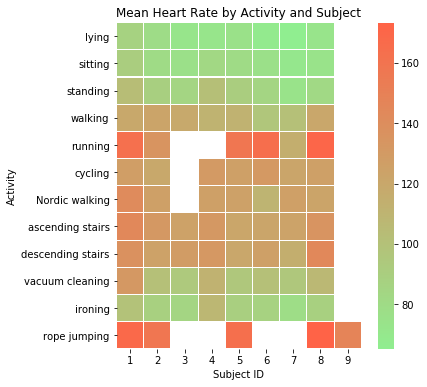

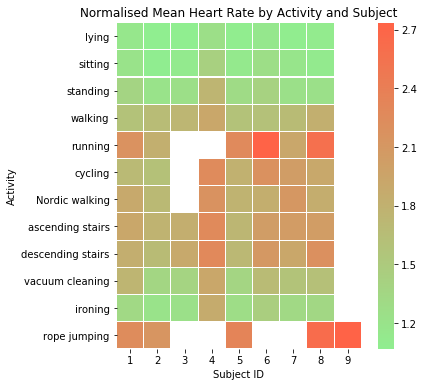

In [22]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Mean Heart Rate by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean']].pivot(index='activity_id', columns='sub_id', values='hr_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Normalised Mean Heart Rate by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean_normal']].pivot(index='activity_id', columns='sub_id', values='hr_mean_normal')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)


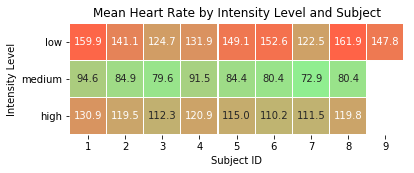

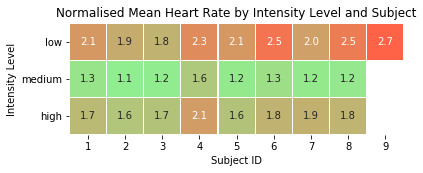

In [23]:
df = train_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean']].pivot(index='act_level', columns='sub_id', values='hr_mean')
    
yticks = ['low','medium','high']
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Intensity Level'
xlabel = 'Subject ID'
title = 'Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)

df = train_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean_normal']].pivot(index='act_level', columns='sub_id', values='hr_mean_normal')
title = 'Normalised Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)


In [24]:
# HAND TEMPERATURE BY ACTIVITY AND SUBJECT 

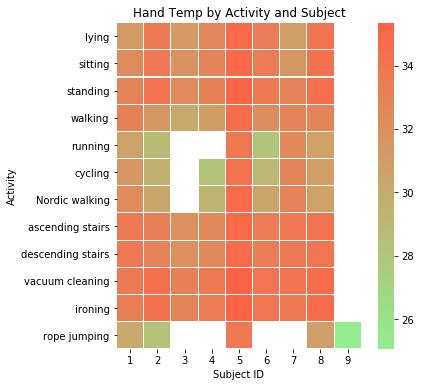

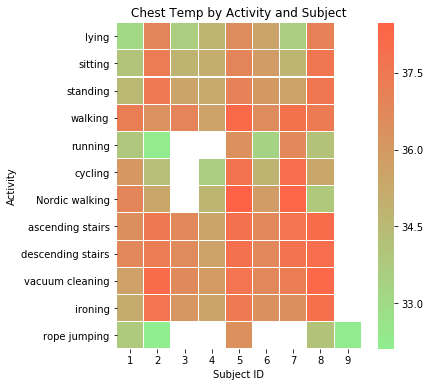

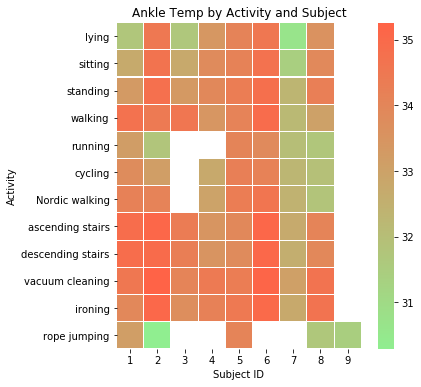

In [25]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Hand Temp by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hand_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='hand_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Chest Temp by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','chest_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='chest_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Ankle Temp by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','ankle_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='ankle_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)


In [89]:
# IMPORT SKLEARN MODULES

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.utils.multiclass import unique_labels

In [74]:
# DEFINE CUSTOM CONFUSION MATRIX

def confusion_matrix(predict_labels, real_labels, cats, title):

    pred_results = {}
    base_dict = {}
    
    #If cats parameter is False, the matrix is created with activity data from protocol activities (or soldier_acts)
    if not cats:
        for i in protocol_acts:
            base_dict[i]=0
        for i in protocol_acts:
            pred_results[i] = base_dict.copy()
    else:
        for i in cats:
            base_dict[i]=0
        for i in cats:
            pred_results[i] = base_dict.copy()
    
    #Dictionary is created counting real values for predicted labels
    for pl,tl in list(zip(predict_labels,  real_labels)):
        pred_results[pl][tl]+=1

    pred_results_df = pd.DataFrame(pred_results)
    if not cats:
        pred_results_df.columns=[activity_id[x] for x in protocol_acts]
        pred_results_df.index = [activity_id[x] for x in protocol_acts]
    
    #Accuracy, precision, recall and f-score are calculated using sklearn library
    precision = precision_score(real_labels, predict_labels, average='macro')
    recall = recall_score(real_labels, predict_labels, average='macro')
    accuracy = accuracy_score(real_labels, predict_labels)
    fscore = f1_score(real_labels, predict_labels, average='macro')
    
    #Display results
    print((title))
    display((pred_results_df))
    print(('Accuracy: ' + str(accuracy)))
    print(('Precision: ' + str(precision)))
    print(('Recall: ' + str(recall)))
    print(('F-score: ' + str(fscore)))


In [ ]:
# ACTIVITY PREDICTION MODELS

In [80]:
DT_Classifier1 = tree.DecisionTreeClassifier()

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier1.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = DT_Classifier1.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['low','medium','high'], "Confusion Matrix for Decision Tree using HR features only")

Confusion Matrix for Decision Tree using HR features only


,low,medium,high
high,8,162,446
low,2018,129,4
medium,137,2008,134


Accuracy: 0.8862465319064605
Precision: 0.8566951114266654
Recall: 0.8477608214734166
F-score: 0.8520436495277953


In [81]:
#SVM_Classifier = svm.SVC(kernel='linear', C=0.25) This is suboptimal!
SVM_Classifier1 = svm.SVC(gamma='auto')

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier1.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = SVM_Classifier1.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['low','medium','high'], "Confusion Matrix for SVM using HR features only")

Confusion Matrix for SVM using HR features only


,low,medium,high
high,5,152,459
low,1902,247,2
medium,141,2049,89


Accuracy: 0.8739595719381689
Precision: 0.8667553986556743
Recall: 0.8428161005915232
F-score: 0.8533905489211676


In [82]:
# ACCELEROMETER PREDICTION MODEL COMPARISONS

In [83]:
DT_Classifier2 = tree.DecisionTreeClassifier()

features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier2.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = DT_Classifier2.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer features")


Confusion Matrix for Decision Tree using Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,488,2,0,0,0,0,3,0,0,0,0
standing,0,5,472,0,0,2,0,3,1,0,0,0
walking,0,0,0,656,0,0,2,0,0,0,4,6
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,1,0,0,0,424,0,0,8,0,2,2
Nordic walking,0,0,0,0,0,0,512,0,0,0,0,1
ironing,0,0,0,4,0,0,0,0,1,0,245,7
vacuum cleaning,0,0,0,2,0,0,0,0,1,0,2,198
rope jumping,0,2,2,0,0,7,0,11,435,0,1,0


Accuracy: 0.9772096710265556
Precision: 0.9753423397839978
Recall: 0.9764230919508089
F-score: 0.9757739708736386


In [84]:
SVM_Classifier2 = svm.SVC(gamma='auto')

features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier2.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = SVM_Classifier2.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for SVM using Accelerometer features")



Confusion Matrix for SVM using Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,492,0,0,0,0,0,1,0,0,0,0
standing,0,2,478,0,0,0,0,3,0,0,0,0
walking,0,0,0,668,0,0,0,0,0,0,0,0
running,0,0,0,0,241,0,0,0,1,0,0,0
cycling,0,0,0,0,0,437,0,0,0,0,0,0
Nordic walking,0,0,0,0,0,0,513,0,0,0,0,0
ironing,0,0,0,0,0,0,0,0,0,0,257,0
vacuum cleaning,0,0,0,0,0,0,0,0,0,0,0,203
rope jumping,0,0,0,0,0,1,0,2,455,0,0,0


Accuracy: 0.9980182322631788
Precision: 0.9985274156718051
Recall: 0.9980780988179
F-score: 0.998297814487803


In [85]:
DT_Classifier3 = tree.DecisionTreeClassifier()

features_used = ['ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier3.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = DT_Classifier3.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Ankle Accelerometer features")


Confusion Matrix for Decision Tree using Ankle Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,458,8,0,0,2,0,17,8,0,0,0
standing,0,16,384,0,0,0,0,65,18,0,0,0
walking,0,0,0,622,1,0,43,0,0,0,0,2
running,0,0,0,1,237,0,0,0,0,3,0,1
cycling,0,2,1,0,0,424,0,0,6,1,3,0
Nordic walking,0,0,0,23,0,0,488,0,0,0,0,2
ironing,0,0,0,1,0,0,0,0,4,3,243,6
vacuum cleaning,0,0,0,3,2,0,2,0,1,1,8,186
rope jumping,0,4,12,2,0,1,0,42,395,0,1,1


Accuracy: 0.9064605628220372
Precision: 0.9152468839447812
Recall: 0.9166455437662818
F-score: 0.915722576387248


In [86]:
DT_Classifier4 = tree.DecisionTreeClassifier()

features_used = ['chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier4.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = DT_Classifier4.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Chest Accelerometer features")


Confusion Matrix for Decision Tree using Chest Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,4,432,43,0,0,1,0,10,3,0,0,0
standing,2,50,411,0,0,2,0,18,0,0,0,0
walking,1,0,0,631,0,0,21,0,0,0,11,4
running,0,0,0,0,238,0,0,0,0,3,0,1
cycling,0,3,0,0,0,425,0,2,6,0,1,0
Nordic walking,0,0,0,14,0,0,492,0,0,0,3,4
ironing,0,0,0,13,0,2,15,0,0,0,224,3
vacuum cleaning,0,0,0,3,0,0,2,0,0,0,5,193
rope jumping,0,9,2,1,0,5,1,25,413,0,2,0


Accuracy: 0.9278636543797067
Precision: 0.9329675775398204
Recall: 0.9319822613566154
F-score: 0.932385736340215


In [87]:
SVM_Classifier3 = svm.SVC(gamma='auto')

features_used = ['ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier3.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = SVM_Classifier3.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for SVM using Ankle Accelerometer features")

Confusion Matrix for SVM using Ankle Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,460,14,0,0,0,0,10,9,0,0,0
standing,0,31,351,0,0,0,0,82,19,0,0,0
walking,0,0,0,635,0,0,33,0,0,0,0,0
running,0,0,0,0,241,0,0,0,0,1,0,0
cycling,0,0,0,0,0,431,0,0,6,0,0,0
Nordic walking,0,0,0,51,0,0,462,0,0,0,0,0
ironing,0,0,0,2,0,0,0,0,0,2,249,4
vacuum cleaning,0,0,0,0,0,0,0,0,0,0,2,201
rope jumping,0,0,3,2,0,3,0,41,407,0,0,2


Accuracy: 0.9064605628220372
Precision: 0.9229050352303858
Recall: 0.924607327114615
F-score: 0.9235355870463886


In [88]:
SVM_Classifier4 = svm.SVC(gamma='auto')

features_used = ['chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier4.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = SVM_Classifier4.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for SVM using Chest Accelerometer features")


Confusion Matrix for SVM using Chest Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,444,39,0,0,0,0,7,3,0,0,0
standing,0,88,378,0,0,1,0,16,0,0,0,0
walking,0,0,0,640,0,0,16,0,0,0,12,0
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,4,0,0,0,428,0,0,5,0,0,0
Nordic walking,0,0,0,27,0,0,485,0,0,0,1,0
ironing,0,0,0,9,0,0,5,0,0,0,237,6
vacuum cleaning,0,0,0,4,0,0,2,0,0,0,0,197
rope jumping,0,0,0,2,0,3,0,27,426,0,0,0


Accuracy: 0.9371779627427665
Precision: 0.9462701521617842
Recall: 0.9421928687316096
F-score: 0.9438802278867149


In [61]:
# SEPARATE PARTICIPANTS


In [ ]:
#Isolate subjects 1,2,5, and 8

In [ ]:
# EXPORT SQL FILE FOR FLASK